Практика пи21-1

2 вопрос

2. Реализовав сверточную нейронную сеть при помощи Pytorch, решите задачу классификации изображений.
3. Разделите набор данных на обучающее и тестовое множество. Выполните предобработку данных(приведите изображения к одному размеру и преобразуйте в тензоры).
4. Отобразите графики значений функции потерь на обучающем множестве. Отобразите confusion matrix и classification report, рассчитанные на основе тестового множества.

Датасет images/chars


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

32*32


128*128

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Оставляем сверточные слои без изменений
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


base_transform = transforms.Compose([
    transforms.Resize((128, 128)), 
])
train_transform = transforms.Compose([
    *base_transform.transforms,
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [4]:
data_path = 'images/chars'
dataset = datasets.ImageFolder(root=data_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SimpleCNN() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10
------------------------------------------------------------
Train Loss: 1.0160 Acc: 0.5208
Test Loss: 0.6662 Acc: 0.6119

Epoch 2/10
------------------------------------------------------------
Train Loss: 0.6883 Acc: 0.5736
Test Loss: 0.6621 Acc: 0.6119

Epoch 3/10
------------------------------------------------------------
Train Loss: 0.6751 Acc: 0.5736
Test Loss: 0.6469 Acc: 0.6119

Epoch 4/10
------------------------------------------------------------
Train Loss: 0.6430 Acc: 0.5736
Test Loss: 0.6332 Acc: 0.6119

Epoch 5/10
------------------------------------------------------------
Train Loss: 0.6232 Acc: 0.6151
Test Loss: 0.6796 Acc: 0.6119

Epoch 6/10
------------------------------------------------------------
Train Loss: 0.6473 Acc: 0.6566
Test Loss: 0.6525 Acc: 0.6119

Epoch 7/10
------------------------------------------------------------
Train Loss: 0.6006 Acc: 0.6981
Test Loss: 0.6417 Acc: 0.5522

Epoch 8/10
---------------------------------------------------

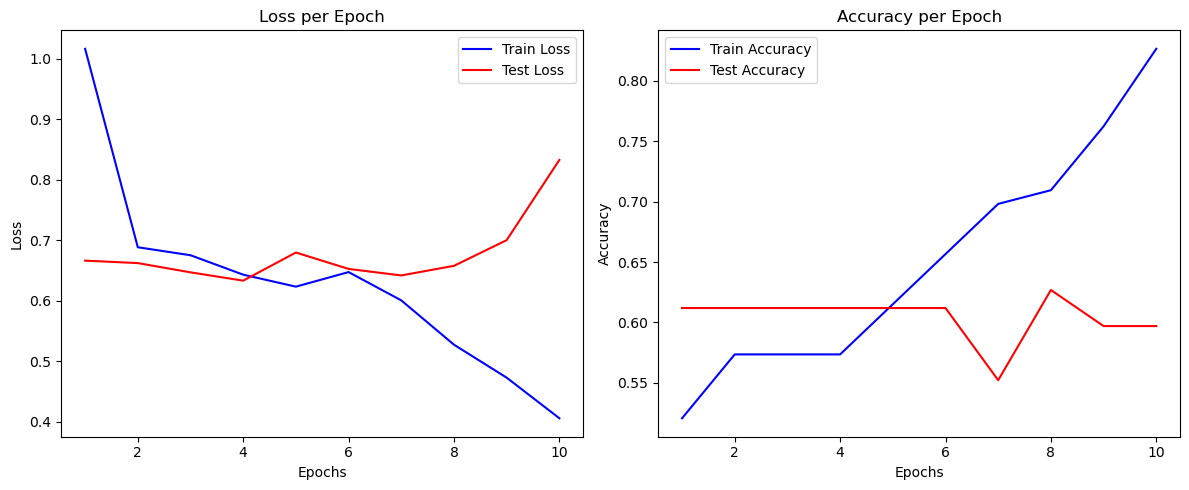

In [7]:
num_epochs=10
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        train_epoch_loss = running_loss / len(train_loader.dataset)
        train_epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_acc)

        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        test_epoch_loss = running_loss / len(test_loader.dataset)
        test_epoch_acc = running_corrects.double() / len(test_loader.dataset)
        test_losses.append(test_epoch_loss)
        test_accuracies.append(test_epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        print(f'Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}\n')

    return train_losses, train_accuracies, test_losses, test_accuracies

train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs
)

def plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies)

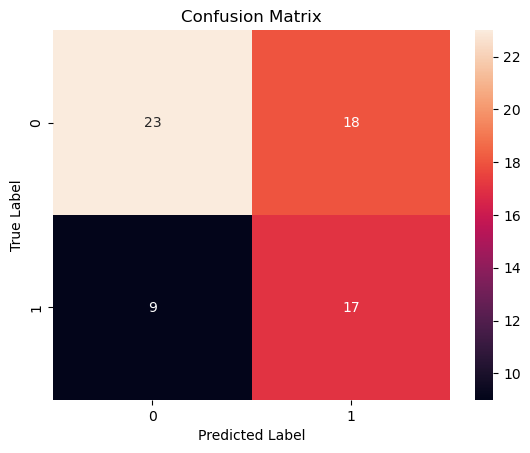

              precision    recall  f1-score   support

           0       0.72      0.56      0.63        41
           1       0.49      0.65      0.56        26

    accuracy                           0.60        67
   macro avg       0.60      0.61      0.59        67
weighted avg       0.63      0.60      0.60        67



In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(classification_report(y_true, y_pred))

evaluate_model(model, test_loader)

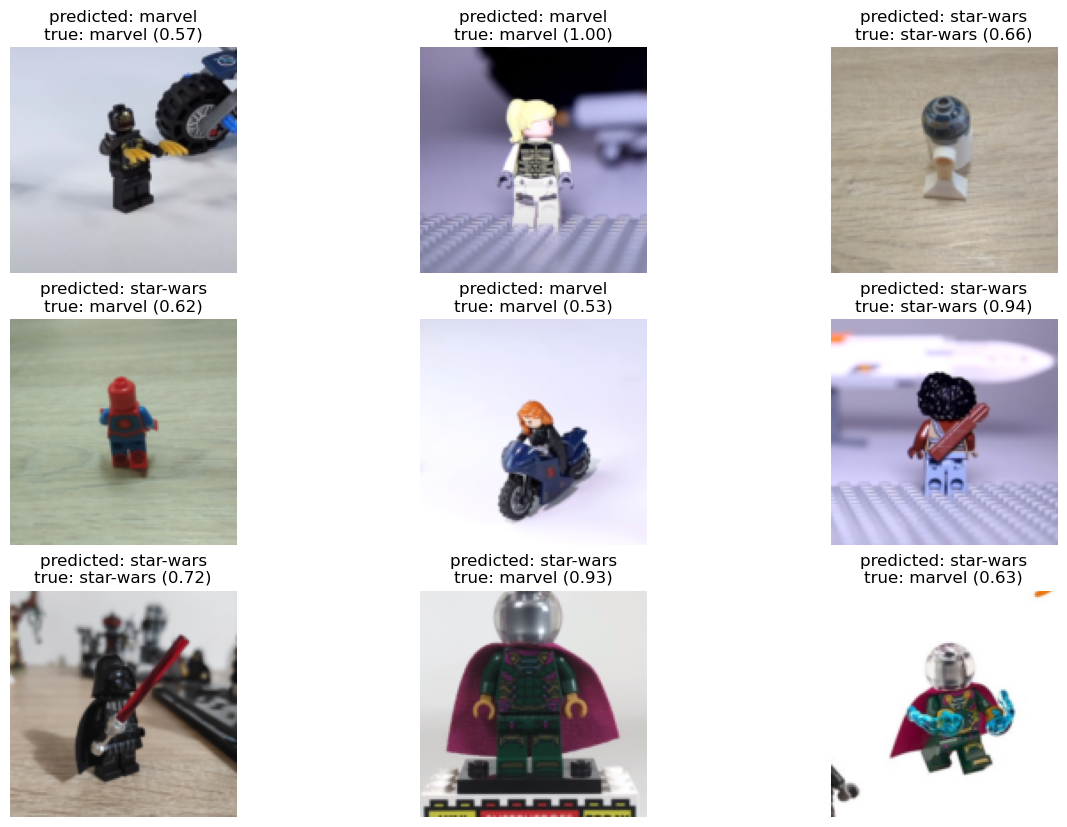

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
device = 'cpu'
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)  

def visualize_model(model, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))  

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}\ntrue: {} ({:.2f})'.format(
                    dataset.classes[preds[j]], dataset.classes[labels[j]], probabilities[j][preds[j]].item()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()  
                    return
        model.train(mode=was_training)

visualize_model(model, num_images=9)  

Вопрос 3

3. При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch,
4. найдите минимум функции y = (3x^2) - 6x + pi на отрезке [-5, 5].
5. Реализуйте процесс поиска экстремума таким образом,
6. чтобы при нахождении точки экстремума процедура поиска останавливалась.
7. Продемонстрируйте процесс оптимизации. Изобразите график функции y(x) на заданном отрезке.

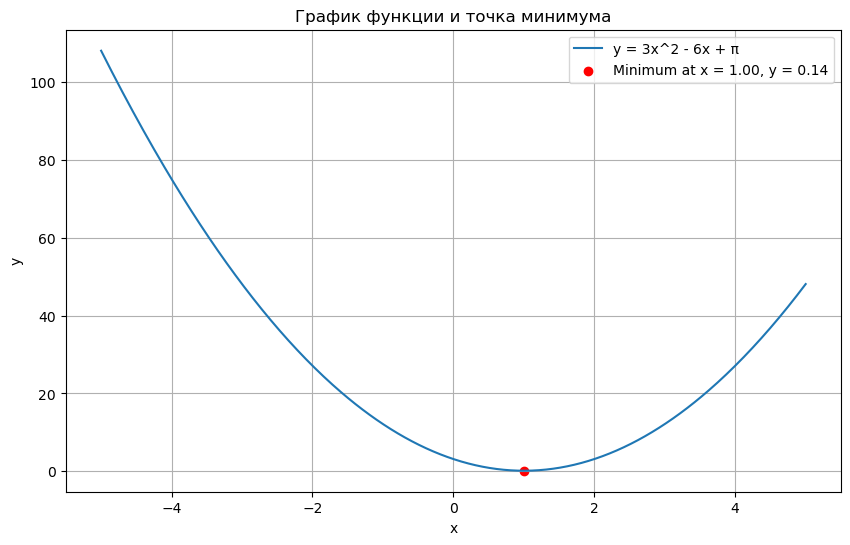

(0.9999985694885254, tensor(0.1416))

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def function(x):
    return 3 * x ** 2 - 6 * x + np.pi

def gradient_descent(starting_point, learning_rate=0.01, tolerance=1e-5, max_iterations=1000):
    x = torch.tensor([starting_point], requires_grad=True)
    optimizer = torch.optim.SGD([x], lr=learning_rate)

    for i in range(max_iterations):
        optimizer.zero_grad()
        y = function(x)
        y.backward()
        optimizer.step()
        if x.grad.abs() < tolerance:
            break

    return x.item()

starting_point = torch.tensor(-5.0)

minimum_x = gradient_descent(starting_point)
minimum_y = function(torch.tensor(minimum_x))

x_values = np.linspace(-5, 5, 400)
y_values = function(torch.tensor(x_values))

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='y = 3x^2 - 6x + π')
plt.scatter(minimum_x, minimum_y, color='red', label=f'Minimum at x = {minimum_x:.2f}, y = {minimum_y:.2f}')
plt.title('График функции и точка минимума')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

minimum_x, minimum_y

In [11]:
minimum_x, minimum_y

(0.9999985694885254, tensor(0.1416))

Практика пм21 2023(как я понял подходит пм21-1, пм21-2, пм21-3)

Bilet 1

2 вопрос (20 баллов)
Задать два двумерных тензора ar1 и ar2 размерности (4, 7), состоящих из случайных целых чисел в пределах 
от 0 до 10. Построить двумерный тензор размерности (4, 7), каждый элемент которого представляет собой 
максимум из двух значений, находящихся на аналогичной позиции в тензорах ar1, ar2. 

In [2]:
import torch

ar1 = torch.randint(0, 11, (4, 7))
ar2 = torch.randint(0, 11, (4, 7))

max_tensor = torch.max(ar1, ar2)

ar1, ar2, max_tensor

(tensor([[ 6,  5,  1,  7,  3,  0,  2],
         [ 6,  1,  9,  2,  1,  7,  7],
         [ 2,  5,  7,  1,  0,  5,  9],
         [ 6,  4,  5, 10,  1,  6,  0]]),
 tensor([[ 2,  3,  5,  5,  5,  0,  4],
         [ 8, 10,  9, 10,  8,  9,  8],
         [ 5,  6,  9,  0,  4,  2,  8],
         [ 9,  6,  7,  2,  3,  5,  0]]),
 tensor([[ 6,  5,  5,  7,  5,  0,  4],
         [ 8, 10,  9, 10,  8,  9,  8],
         [ 5,  6,  9,  1,  4,  5,  9],
         [ 9,  6,  7, 10,  3,  6,  0]]))

3 вопрос (20 баллов) 
Реализовать методы forward и backward в полносвязном слое. Входные данные обязательно должны быть в 
виде батчей (то есть кол-во измерений в inputs 2). Нельзя использовать готовую реализацию обратного 
распространения из PyTorch.
Шаблон кода, который можно использовать за основу: https://pastebin.com/Ugvjf6PA

In [3]:
import torch
from typing import Optional

class Linear:
    def __init__(self, n_inputs: int, n_neurons: int):
        self.weights = torch.randn(n_inputs, n_neurons) * 0.01
        self.biases = torch.randn(n_neurons) * 0.01
        self.inputs: Optional[torch.Tensor] = None

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        assert inputs.ndim == 2
        self.inputs = inputs
        return torch.mm(inputs, self.weights) + self.biases

    def backward(self, dvalue: torch.Tensor) -> None:
        self.dweights = torch.mm(self.inputs.T, dvalue)
        self.dbiases = dvalue.sum(axis=0)

        self.dinput = torch.mm(dvalue, self.weights.T)

linear_layer = Linear(n_inputs=3, n_neurons=2)

inputs = torch.randn(4, 3)

output = linear_layer.forward(inputs)

dvalue = torch.randn(4, 2)

linear_layer.backward(dvalue)

output, linear_layer.dweights, linear_layer.dbiases, linear_layer.dinput

(tensor([[-0.0134, -0.0521],
         [-0.0123,  0.0227],
         [-0.0184, -0.0119],
         [ 0.0059,  0.0274]]),
 tensor([[ 6.3270,  0.6632],
         [-3.4888, -1.4200],
         [ 0.9607,  0.5278]]),
 tensor([ 0.0710, -1.7500]),
 tensor([[-0.0223,  0.0239,  0.0161],
         [-0.0119, -0.0037, -0.0081],
         [ 0.0138, -0.0042,  0.0007],
         [-0.0136,  0.0028, -0.0021]]))

Bilet 2

2 вопрос (20 баллов)
Используя операции над матрицами и векторами из библиотеки PyTorch реализовать полносвязный слой с 
заданными весами weights и biases. Прогнать вектор inputs через слой и вывести результат. Входные данные 
обязательно должны быть в виде батчей (то есть кол-во измерений в inputs 2). Нельзя использовать готовые 
слои из PyTorch.

In [4]:
import torch

weights = torch.tensor([[0.2, 0.3], [0.4, 0.5], [0.6, 0.7]])
biases = torch.tensor([0.1, 0.2, 0.3])

inputs = torch.tensor([[1.0, 2.0], [3.0, 4.0]])

def fully_connected_layer(inputs, weights, biases):
    return torch.matmul(inputs, weights.T) + biases

output = fully_connected_layer(inputs, weights, biases)
output

tensor([[0.9000, 1.6000, 2.3000],
        [1.9000, 3.4000, 4.9000]])

In [5]:
#альтернатива

import torch

class Linear:
    def __init__(self, n_features, n_neurons):
        self.weights = torch.randn((n_features, n_neurons))
        self.biases = torch.randn(n_neurons)
  
    def forward(self, inputs):
        return (inputs @ self.weights) + self.biases  # torch.matmul(inputs, self.weights) + self.biases

weights = torch.randn(4, 3)
weights

inputs = torch.tensor([[1, 2, 3, 2.5], 
                       [2, 5, -1, 2], 
                       [-1.5, 2.7, 3.3, -0.8]])
inputs @ weights

linear = Linear(n_features = 4, n_neurons = 3)
linear.forward(inputs)

tensor([[ -2.9642,  -9.2975,  -3.0941],
        [  3.0112, -14.0425,  -5.2061],
        [  0.9946,  -5.1898,   2.7022]])

3 вопрос (20 баллов) 
При помощи готовых слоев PyTorch реализуйте класс модели, который:
содержит слои Conv2d, Linear;
может принимать изображение с 3 каналами;
возвращает вектор из 10 чисел для каждого фото;
числа в этом векторе принимают значения от 0 до +бесконечности. 
Кол-во слоев, каналов внутри сверток и т.д. можете выбирать сами.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=os.cpu_count())

net = CIFAR10CNN()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images.to(device)

outputs = net(images)
outputs.detach().cpu()

Files already downloaded and verified


tensor([[-0.0177, -0.0054,  0.0025, -0.0582,  0.0430,  0.0230, -0.0412,  0.0331,
          0.0337, -0.0660],
        [-0.0654,  0.0119, -0.0001, -0.0452, -0.0086,  0.0040, -0.0160,  0.0231,
          0.0285, -0.0988],
        [-0.0654, -0.0045,  0.0126, -0.0529, -0.0281,  0.0421, -0.0341, -0.0257,
          0.0202, -0.0788],
        [-0.0296, -0.0066,  0.0092, -0.0758,  0.0198,  0.0128, -0.0403,  0.0214,
          0.0271, -0.0583]])

А теперь практика моей группы - пи21-2(может быть тоже самое Ахмад выслал и пи21-4, пи21-3, пи21-6)

Vopros 2

﻿2. При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции y = x^3 - 6√x + 1 на отрезке [0, 10]. 
Реализуйте процесс поиска экстремума таким образом, чтобы при точки экстремума процедура поиска останавливалась. 
Продемонстрируйте процесс оптимизации. Изобразите график функции у(х) на заданном отрезке. (20 баллов).
нахождении

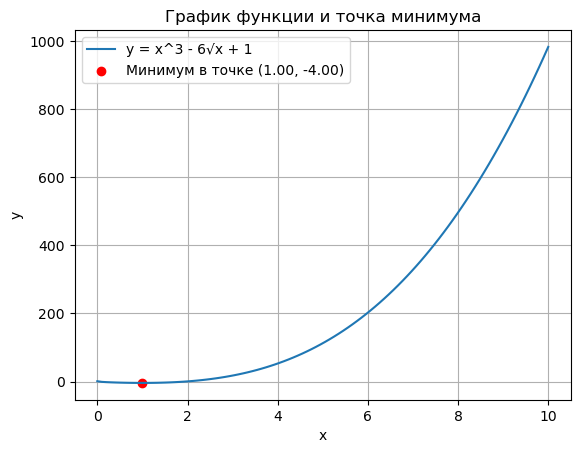

(1.0000011920928955, -4.0)

In [7]:
import torch
import matplotlib.pyplot as plt

def function(x):
    return x**3 - 6*torch.sqrt(x) + 1

x = torch.tensor([10.0], requires_grad=True)

optimizer = torch.optim.SGD([x], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()
    y = function(x)
    y.backward()
    optimizer.step()
    if x.grad.norm() < 1e-5:
        break

minimum = x.item()
minimum_value = function(x).item()


x_graph = torch.linspace(0, 10, 100)
y_graph = function(x_graph).detach()

plt.plot(x_graph, y_graph, label="y = x^3 - 6√x + 1")
plt.scatter(minimum, minimum_value, color='red', label=f"Минимум в точке ({minimum:.2f}, {minimum_value:.2f})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("График функции и точка минимума")
plt.grid(True)
plt.show()

minimum, minimum_value

Vopros 3

[nltk_data] Downloading package punkt to /home/qtr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda
Количество экземпляров в обучающей выборке по классам: Counter({'ACTIVITY': 4008, 'REVIEW': 2992})
Количество экземпляров в тестовой выборке по классам: Counter({'ACTIVITY': 1718, 'REVIEW': 1282})
Обучающая выборка сбалансирована: False
Тестовая выборка сбалансирована: False
Epoch 1/20
Train Loss: 0.7079 Acc: 0.4997
Test Loss: 0.6914 Acc: 0.5847
------------------------------------------------------------
Epoch 2/20
Train Loss: 0.6919 Acc: 0.5070
Test Loss: 0.6910 Acc: 0.4240
------------------------------------------------------------
Epoch 3/20
Train Loss: 0.6889 Acc: 0.5300
Test Loss: 0.6878 Acc: 0.5870
------------------------------------------------------------
Epoch 4/20
Train Loss: 0.6901 Acc: 0.5129
Test Loss: 0.6878 Acc: 0.5887
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.7332 Acc: 0.5214
Test Loss: 0.6946 Acc: 0.4260
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.7021 Acc: 0.502

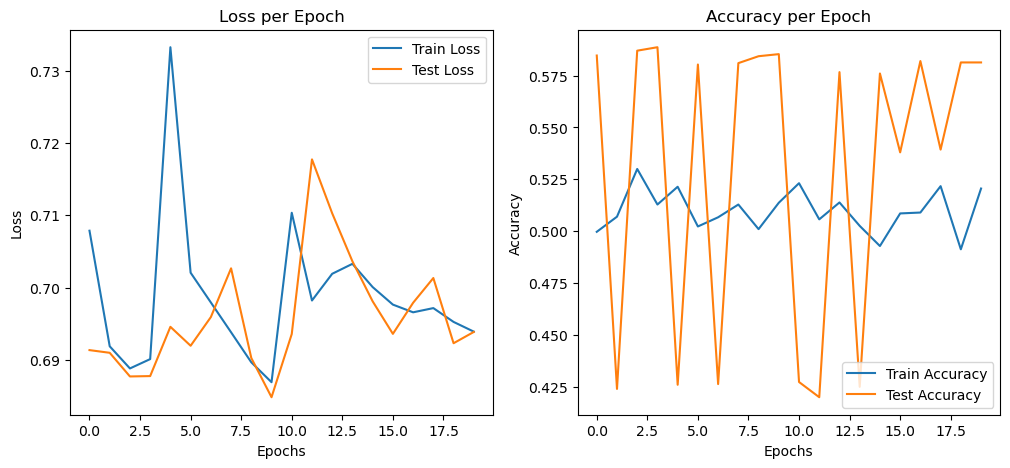

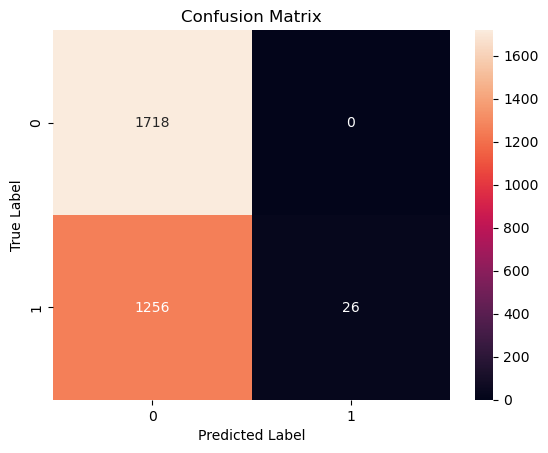

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1718
           1       1.00      0.02      0.04      1282

    accuracy                           0.58      3000
   macro avg       0.79      0.51      0.39      3000
weighted avg       0.76      0.58      0.44      3000



In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
import nltk
import seaborn as sns
nltk.download('punkt')

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data = pd.read_csv('nlp/activities.csv')

X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Review-Activity'], test_size=0.3, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

print(f"Количество экземпляров в обучающей выборке по классам: {train_class_counts}")
print(f"Количество экземпляров в тестовой выборке по классам: {test_class_counts}")

is_balanced_train = len(set(train_class_counts.values())) == 1
is_balanced_test = len(set(test_class_counts.values())) == 1

print(f"Обучающая выборка сбалансирована: {is_balanced_train}")
print(f"Тестовая выборка сбалансирована: {is_balanced_test}")

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

word_counts = Counter(word for text in X_train for word in word_tokenize(text.lower()))
vocab = {word: i + 1 for i, (word, count) in enumerate(word_counts.items())}

def text_to_sequence(text, vocab):
    return [vocab.get(word, 0) for word in word_tokenize(text.lower())]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = list(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_sequence = text_to_sequence(self.texts[idx], vocab)
        return torch.tensor(text_sequence, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return sequences_padded, labels

train_dataset = TextDataset(X_train, y_train_encoded)
test_dataset = TextDataset(X_test, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=96, shuffle=False, collate_fn=collate_fn)

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab) + 1
embedding_dim = 200
hidden_size = 256
num_classes = len(np.unique(y_train_encoded))

model = RNN(vocab_size, embedding_dim, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for sequences_padded, labels in train_loader:
        sequences_padded, labels = sequences_padded.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences_padded)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for sequences_padded, labels in test_loader:
            sequences_padded, labels = sequences_padded.to(device), labels.to(device)
            outputs = model(sequences_padded)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f}')
    print(f'Test Loss: {test_losses[-1]:.4f} Acc: {test_accuracies[-1]:.4f}')
    print('-' * 60)

# Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Оценка модели и вывод матрицы ошибок
y_pred = []
y_true = []
with torch.no_grad():
    for sequences_padded, labels in test_loader:
        sequences_padded, labels = sequences_padded.to(device), labels.to(device)
        outputs = model(sequences_padded)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred))